In [13]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import signal
import matplotlib.mlab as mlab
plt.ion()

# PHYS 512 - Problem Set 4
Tristan Ménard<br>
260675783

In [2]:
# Read the LIGO data
directory = 'C:/Users/Trix/Documents/GitHub/phys512-problem-sets/ProblemSet4/LOSC_Event_tutorial/LOSC_Event_tutorial/'

def read_template(filename):
    dataFile = h5py.File(filename,'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(filename, 'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    
    meta = dataFile['meta']
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0*duration)/len(strain)
    
    dataFile.close()
    return strain, dt, utc

fname = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
print('Reading file', fname)
strain_H, dt_H, utc_H = read_file(directory+fname)

fname = 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
print('Reading file', fname)
strain_L, dt_L, utc_L = read_file(directory+fname)

template_name = 'GW150914_4_template.hdf5'
print('Reading template', template_name)
th, tl = read_template(directory+template_name)

Reading file H-H1_LOSC_4_V2-1126259446-32.hdf5
Reading file L-L1_LOSC_4_V2-1126259446-32.hdf5
Reading template GW150914_4_template.hdf5


In [3]:
# Both Hanford and Livingston have the same sampling rate
dt = dt_L
samp = int(1/dt)
print('Use', samp, 'Hz sampling rate from file', fname)

Use 4096 Hz sampling rate from file L-L1_LOSC_4_V2-1126259446-32.hdf5


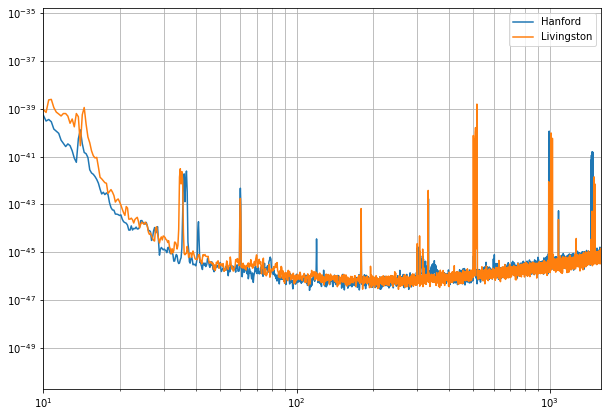

In [43]:
# Calculate the power spectral density (PSD)

# Use 4 seconds of data for each fourier transform
NFFT = 4*samp
# Number of points of overlap between segments used in Welch averaging
overlap = 1*NFFT/2

# psd_window = signal.turkey(NFFT, alpha=1/4)
psd_window = signal.hann(NFFT)

# Calculate PSD using Welch averaging
PSD_H, freq = mlab.psd(strain_H, Fs=samp, NFFT=NFFT, window=psd_window, noverlap=overlap)
PSD_L, freq = mlab.psd(strain_L, Fs=samp, NFFT=NFFT, window=psd_window, noverlap=overlap)

# Plot the Welch-averaged PSDs
plt.figure(figsize=(10,7))
plt.loglog(freq, PSD_H, label='Hanford')
plt.loglog(freq, PSD_L, label='Livingston')
plt.xlim(10,1600)
plt.legend()
plt.grid(which='both')

In [103]:
npts = len(strain_H)
n1 = np.abs(np.fft.rfft(strain_H[:int(3*npts/2)]*np.hanning(int(3*npts/2))))**2
n2 = np.abs(np.fft.rfft(strain_H[int(npts/2):]*np.hanning(int(3*npts/2))))**2
plt.loglog(n1)
plt.loglog(n2)
plt.loglog((n1+n2)/2)

ValueError: operands could not be broadcast together with shapes (131072,) (196608,) 

In [108]:
np.hanning(int(npts/2)).shape

(65536,)

In [116]:
strain_H[:int(npts/2)].shape

(65536,)

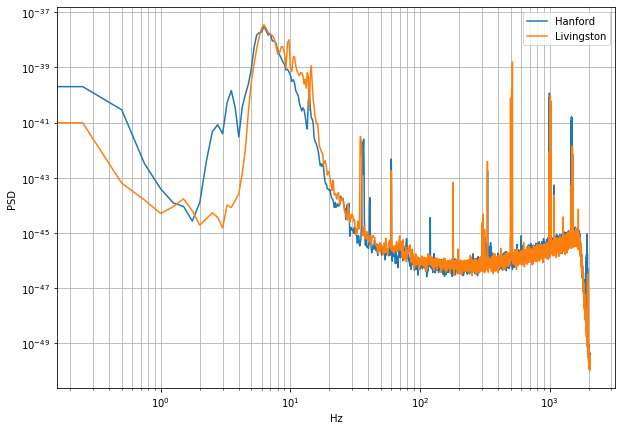

In [93]:
# Use the power spectral density of each instrument as the respective noise model
# noise_H = np.abs(np.fft.rfft(strain_H*np.hanning(len(strain_H))))**2
# noise_L = np.abs(np.fft.rfft(strain_L*np.hanning(len(strain_L))))**2

# Convert the time axis to Fourier space using np.fft.rfftfreq()
# freq = np.fft.rfftfreq(len(strain_H), dt)

# Use Welch's method to get the power spectral density (PSD) of the Hanford and Livingston data.
# Consider the PSD to be the noise model for its respective instrument.
# Welch's method smooths the noise model by averaging overlapping segments of the data.
NFFT = 4*samp # use 4 seconds of data for each fourier transform
n_overlap = NFFT/2 # overlap half the points
# Use a Hanning window along with Welch's method:
freq, noise_avg_H = signal.welch(strain_H, fs=samp, nfft=NFFT, window='hanning', noverlap=n_overlap, nperseg=NFFT) 
freq, noise_avg_L = signal.welch(strain_L, fs=samp, nfft=NFFT, window='hanning', noverlap=n_overlap, nperseg=NFFT)

plt.figure(figsize=(10,7))

# plt.loglog(freq, noise_H, alpha=0.85, label='Hanford')
# plt.loglog(freq, noise_L, alpha=0.85, label='Livingston')

plt.loglog(freq, noise_avg_H, label='Hanford')
plt.loglog(freq, noise_avg_L, label='Livingston')

plt.grid(which='both')
plt.xlabel('Hz')
plt.ylabel('PSD')
# plt.xlim(10,1600)
plt.legend()

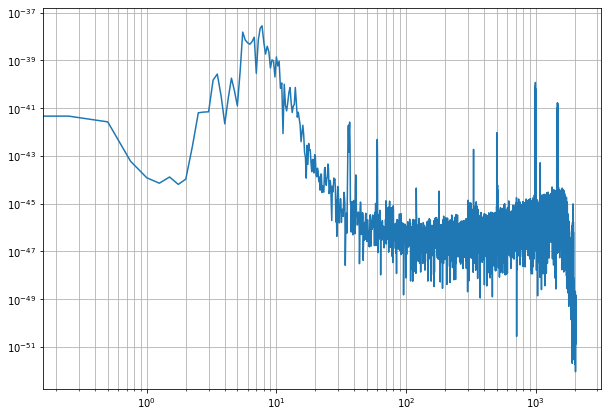

In [79]:
f, Pxx_den = signal.periodogram(strain_H, fs=samp, window='hanning', nfft=NFFT)
plt.figure(figsize=(10,7))
plt.loglog(f, Pxx_den)
plt.grid(which='both')
# plt.xlim(10,1600)

In [ ]:
N0_H = (N_H + np.roll(N_H,-1) + np.roll(N_H, 1))/3
N0_L = (N_L + np.roll(N_L,-1) + np.roll(N_L, 1))/3
for i in range(10):
    N0_H = (N0_H + np.roll(N0_H,-1) + np.roll(N0_H, 1))/3
    N0_L = (N0_L + np.roll(N0_L,-1) + np.roll(N0_L, 1))/3
    
plt.figure(figsize=(12,8))
plt.loglog(np.fft.rfftfreq(len(Hstrain), Hdt), N0_H, alpha=0.85, label='Hanford')
plt.loglog(np.fft.rfftfreq(len(Lstrain), Ldt), N0_L, alpha=0.85, label='Livingston')
plt.grid(which='both')
plt.legend()

In [ ]:
yft = np.fft.rfft(Hstrain*np.blackman(len(Hstrain)))
template_ft = np.fft.rfft(th)
amp_ft = np.conj(template_ft)*yft/N0_H
amp_top = np.real(amp_ft)

In [ ]:
# plt.plot(amp_top)
plt.plot(amp_top)